# AAC 在AB/AE亚型中问题

## 开始干正事：画图

In [1]:
import sys
sys.path.append("src")
import os
import json

import libpybiofeature

import utils
work_Dir = utils.workdir.workdir(os.getcwd(), 4)

import numpy as np
import pandas as pd

from Bio import SeqIO

random_seed = 42
np.random.seed(random_seed)

In [2]:
def load_AAC_feature(TxSE_args: dict):

    # AAC
    AAC_feature = {
        "name": "AAC",
        "p": libpybiofeature.featurebuilder.build_acc_feature(
            path_to_fasta=TxSE_args['fasta']['p'],
            seq_id_list=[ seq.id for seq in SeqIO.parse(TxSE_args['fasta']['p'], "fasta") ],
            desc='p'
        ),
        "n": libpybiofeature.featurebuilder.build_acc_feature(
            path_to_fasta=TxSE_args['fasta']['n'],
            seq_id_list=[ seq.id for seq in SeqIO.parse(TxSE_args['fasta']['n'], "fasta") ],
            desc='n'
        ),
    }

    print(AAC_feature['n'].shape[0], AAC_feature['p'].shape[0])

    return AAC_feature

In [3]:
prot_type = 6
cter_bool = False
Tx_arg = {
    "type": f'T{prot_type}',
    'fasta': {
        'cter': cter_bool,
        'p': "data/T6SE/anti-bacterial-effector_p.fasta",
        'n': "data/T6SE/anti-bacterial-effector_n.fasta"
    },
}
save_dir = "out/libfeatureselection/Six_feature_research/aac/ab"

In [4]:
aac_data = load_AAC_feature(
    TxSE_args=Tx_arg
)
aa_type = list(aac_data['p'].columns)

n_AAC: 100%|██████████| 53/53 [00:00<00:00, 101924.86it/s]

53 53


In [5]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.use14corefonts'] = False
# mpl.rcParams['pdf.usecorefonts'] = True
mpl.rcParams['pdf.compression'] = 9

import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'nature'])

from matplotlib.ticker import MaxNLocator

import seaborn as sns

In [6]:
aac_data_transformed = pd.concat([aac_data['p'], aac_data['n']], keys=['T6SP-AB', 'non-T6SP']).reset_index(level=0).rename({
    "level_0": "Type"
}, axis=1, inplace=False).melt(id_vars="Type", value_vars=aa_type, ignore_index=False).rename({
    "variable": "Amino acid",
    "value": "AAC"
}, axis=1, inplace=False)

In [7]:
aac_data_transformed

,Type,Amino acid,AAC
WP_005299972.1,T6SP-AB,A,0.091969
NP_248951.1,T6SP-AB,A,0.088112
pdb|6H56|A,T6SP-AB,A,0.118577
PTC37822.1,T6SP-AB,A,0.101695
PTC37818.1,T6SP-AB,A,0.072340
...,...,...,...
lcl|NC_003902.1_prot_NP_637297.1_1900,non-T6SP,Y,0.039720
lcl|AE014613.1_prot_AAO68872.1_1138,non-T6SP,Y,0.076923
lcl|NC_002516.2_prot_NP_249244.1_555,non-T6SP,Y,0.000000
lcl|NZ_CP010310.2_prot_WP_039404597.1_3544,non-T6SP,Y,0.016949


In [9]:
def get_star(p:float):
    if p <= 0.0001:
        return "****"
    elif p <= 0.001:
        return "***"
    elif p <= 0.01:
        return "**"
    elif p <= 0.05:
        return "*"
    else:
        return ""
from scipy.stats import wilcoxon
grouped = aac_data_transformed.groupby("Amino acid")
wilcoxon_result = {}
for name, group in grouped:
    x = group[group['Type'] == 'T6SP-AB']['AAC']
    y = group[group['Type'] == 'non-T6SP']['AAC']
    stat, p = wilcoxon(x, y)
    wilcoxon_result[name] = {
        "statistic": stat,
        "p-value": p
    }
    # print(f'Type: {name}, Wilcoxon rank-sum statistic: {stat:.2f}, p-value: {p:.3f}')
with open(f"{save_dir}/wilcoxon_result.json", "w+", encoding="UTF-8") as f:
    json.dump(wilcoxon_result, f)
aac_data_transformed.to_csv(f"{save_dir}/aac_data_transformed.csv", index_label="Seq_ID")

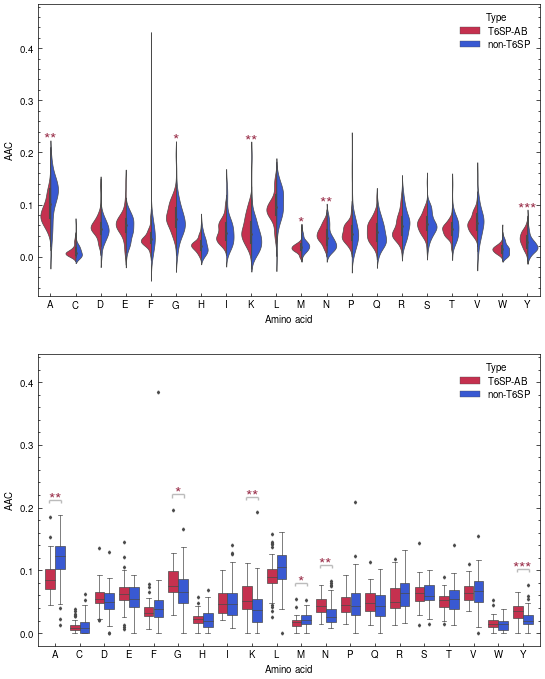

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(19.2 / 4 * 1.35, 10.8 / 3.5 * 2 * 1.35))

sns.violinplot(
    data=aac_data_transformed,
    x="Amino acid",
    y="AAC",
    hue="Type",
    split=True,
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    ax=ax1
)
ax1.set_ylim([aac_data_transformed['AAC'].min() - 0.075, aac_data_transformed['AAC'].max() + 0.1])
ax_xticklabel_origin = ax1.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax1.tick_params(axis='x', length=2, top=False)
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))

for i, (violin_1, violin_2) in enumerate(zip(ax1.collections[0::3], ax1.collections[2::3])):
    center = violin_1.get_paths()[0].vertices[:, 0].mean()
    height = max(violin_1.get_paths()[0].vertices[:, 1].max(), violin_2.get_paths()[0].vertices[:, 1].max())
    ax1.text(i, height, get_star(
        p = wilcoxon_result[ax_xticklabel[i]]["p-value"]
    ), fontsize=12, color="#9b324c", ha='center', va='center')

sns.boxplot(
    data=aac_data_transformed,
    x="Amino acid",
    y="AAC",
    hue="Type",
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    fliersize=1.5,
    ax=ax2
)
ax2.set_ylim([aac_data_transformed['AAC'].min() - 0.02, aac_data_transformed['AAC'].max() + 0.06])
ax_xticklabel_origin = ax2.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax2.tick_params(axis='x', length=2, top=False)
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))

for i, aa in enumerate(ax_xticklabel):
    center = i
    height = max(aac_data_transformed[aac_data_transformed["Amino acid"] == aa]['AAC']) + 0.025
    star_str = get_star(
        p = wilcoxon_result[aa]["p-value"]
    )
    if "*" in star_str:
        ax2.text(center, height, star_str, fontsize=12, color="#9b324c", ha='center', va='center')
        ax2.hlines(height,center-0.25,center+0.25, color="#bbbbbb")
        ax2.vlines(center-0.25,height-0.005, height, color="#bbbbbb")
        ax2.vlines(center+0.25,height-0.005, height, color="#bbbbbb")

# plt.title("AAC Training-Testing Wilcoxon Signed Ranks Test")
plt.savefig(f"{save_dir}/diff.pdf")
plt.show()

# 构建RTX-AAC模型预测non-RTX蛋白

In [11]:
import sys
sys.path.append("src")
import os
# os.environ["n_jobs"] = "2"
import json

import libpybiofeature

import utils
work_Dir = utils.workdir.workdir(os.getcwd(), 4)

import numpy as np
import pandas as pd

from Bio import SeqIO

random_seed = 42
np.random.seed(random_seed)

In [12]:
from sklearn.model_selection import StratifiedKFold

In [13]:
def load_AAC_feature(TxSE_args: dict):

    # AAC
    AAC_feature = {
        "name": "AAC",
        "p": libpybiofeature.featurebuilder.build_acc_feature(
            path_to_fasta=TxSE_args['fasta']['p'],
            seq_id_list=[ seq.id for seq in SeqIO.parse(TxSE_args['fasta']['p'], "fasta") ],
            desc='p'
        ),
        "n": libpybiofeature.featurebuilder.build_acc_feature(
            path_to_fasta=TxSE_args['fasta']['n'],
            seq_id_list=[ seq.id for seq in SeqIO.parse(TxSE_args['fasta']['n'], "fasta") ],
            desc='n'
        ),
    }

    print(AAC_feature['n'].shape[0], AAC_feature['p'].shape[0])

    # # 一般p会少于n，所以随机在n中选择即可
    # AAC_feature['n'] = AAC_feature['n'].iloc[np.random.choice(np.arange(AAC_feature['n'].shape[0]), size=AAC_feature['p'].shape[0], replace=False), :]

    AAC_feature["pn_all_feature"] = pd.concat([
        AAC_feature["p"],
        AAC_feature["n"],
    ])
    AAC_feature["pn_all_label"] = np.concatenate([
        np.ones(shape=(AAC_feature["p"].shape[0], )),
        np.zeros(shape=(AAC_feature["n"].shape[0], )),
    ])

    # 切割train、test
    train_id, test_id = next(iter(StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    ).split(
        AAC_feature["pn_all_feature"].values,
        AAC_feature["pn_all_label"]
    )))

    AAC_feature["training_pn_all_feature"] = AAC_feature["pn_all_feature"].iloc[train_id, :]
    AAC_feature["training_pn_all_label"] = AAC_feature["pn_all_label"][train_id]
    AAC_feature["testing_pn_all_feature"] = AAC_feature["pn_all_feature"].iloc[test_id, :]
    AAC_feature["testing_pn_all_label"] = AAC_feature["pn_all_label"][test_id]

    return AAC_feature

In [14]:
prot_type = 6
cter_bool = False
rtx_Tx_arg = {
    "type": f'T{prot_type}',
    'fasta': {
        'cter': cter_bool,
        'p': "data/T6SE/anti-bacterial-effector_p.fasta",
        'n': "data/T6SE/anti-bacterial-effector_n.fasta"
    },
}
nonrtx_Tx_arg = {
    "type": f'T{prot_type}',
    'fasta': {
        'cter': cter_bool,
        'p': "data/T6SE/anti-eukaryotic-effector_p.fasta",
        'n': "data/T6SE/anti-eukaryotic-effector_n.fasta"
    },
}
model_save_dir = "out/libfeatureselection/Six_feature_research/aac/ab/model/"
os.makedirs(model_save_dir, exist_ok=True)

In [15]:
rtx_aac_data = load_AAC_feature(
    TxSE_args=rtx_Tx_arg
)
nonrtx_aac_data = load_AAC_feature(
    TxSE_args=nonrtx_Tx_arg
)
aa_type = list(rtx_aac_data['p'].columns)
print(rtx_aac_data.keys(), ", ".join(aa_type))

n_AAC: 100%|██████████| 33/33 [00:00<00:00, 99648.69it/s]

53 53
33 33
dict_keys(['name', 'p', 'n', 'pn_all_feature', 'pn_all_label', 'training_pn_all_feature', 'training_pn_all_label', 'testing_pn_all_feature', 'testing_pn_all_label']) A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y


In [16]:
from libfeatureselection import model, model_space
n_jobs = (
    (os.cpu_count() - 2)
    if "n_jobs" not in os.environ or os.environ['n_jobs'] == "" else
    int(os.environ['n_jobs'])
)
n_jobs

2023-07-11 22:41:42.847214: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-11 22:41:42.896412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-11 22:41:42.896420: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-11 22:41:43.909025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-11 22:41:43.909037: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to c

30

In [17]:
search_result_in_a_scheme_df = pd.DataFrame()
for model_index in range(len(model_space.find_space)):
    model_information_summary, searched_result_performance_summary, searched_result_5C_performance_summary = model.MyOptimitzer(
        classifier_name=model_space.find_space[model_index]['name'],
        classifier_class=model_space.find_space[model_index]['class'],
        classifier_param_dict=model_space.find_space[model_index]['param'],
    ).find_best(
        X=rtx_aac_data["pn_all_feature"].values,
        y=rtx_aac_data["pn_all_label"],
        validation=(
            nonrtx_aac_data["pn_all_feature"].values,
            nonrtx_aac_data["pn_all_label"]
        ),
        search_method=(
            "BayesSearchCV"
            if "Bayes" not in model_space.find_space[model_index]
            or model_space.find_space[model_index]['Bayes'] == True
            else "GridSearchCV"
        ),
        n_jobs=n_jobs
    ).get_summary(
        path_to_dir=f"{model_save_dir}/model/"
    )

    # 记录结果，插入到 search_result_in_a_scheme_df
    result_series = pd.concat([
        pd.Series(model_information_summary),
        pd.Series(searched_result_performance_summary),
        pd.Series(searched_result_5C_performance_summary),
    ], keys=[
        "Model_Information",
        "Best_Performance",
        "5FoldCV_Performance",
    ])

    result_series.name = model_index

    search_result_in_a_scheme_df = pd.concat([
        search_result_in_a_scheme_df,
        result_series.to_frame().T
    ], axis=0, ignore_index=False)

    search_result_in_a_scheme_df.index = search_result_in_a_scheme_df.index.set_names(
        ["Model_Type",]
    )

    local_xlsx_path = f"{model_save_dir}/searched_result.xlsx"

    # 缓存 search_result_in_a_scheme_df
    search_result_in_a_scheme_df.to_excel(
        local_xlsx_path,
        "AB-model_Predict_AE",
        freeze_panes=(2, 1)
    )

/home/georgezhao/.pyvirtualenvs/TxSEml_Backend/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/georgezhao/.pyvirtualenvs/TxSEml_Backend/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/georgezhao/.pyvirtualenvs/TxSEml_Backend/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/georgezhao/.pyvirtualenvs/TxSEml_Backend/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 352, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/home/georgezhao/.pyvirtualenvs/TxSEml_Backend/lib/python3.10/site-packages/sklearn/model_selection/_validatio

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>

<Figure size 480x270 with 0 Axes>